# Clasificador de reseñas

- **Joan Pedro Bruxola**
- **Julio García Bustos**
- **Marcos Rosique Martínez**
- **Mario Soto Ramos**

Primero importamos todas las librerías importantes

In [28]:
import numpy as np
import pandas as pd
import requests
import re

from collections import Counter
from wordcloud import WordCloud

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options

from bs4 import BeautifulSoup
import time
from langdetect import detect, LangDetectException
import spacy
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

## Extracción de URLs

### URLs de las películas

In [2]:
# Páginas específicas a scrapear
paginas_objetivo = [2,3,4,5]

# Número de películas a extraer de cada página
n_por_pagina = 24

# URL base
url = "https://www.metacritic.com/browse/movie/"

# Cabecera para evitar bloqueo
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"
}

# Lista para almacenar todos los enlaces
link_list = []

# Iterar por las páginas deseadas
for page in paginas_objetivo:
    print(f"\nAccediendo a página {page}...")

    params = {
        "releaseYearMin": 2015,
        "releaseYearMax": 2020,
        "page": page
    }

    response = requests.get(url, headers=headers, params=params)

    if response.status_code != 200:
        print(f"Error al acceder a la página {page}.")
        continue

    soup = BeautifulSoup(response.content, "html.parser")

    movie_links = soup.find_all("a", class_="c-finderProductCard_container g-color-gray80 u-grid")

    if not movie_links:
        print("No se encontraron películas en esta página.")
        continue

    # Limitar a las primeras `n_por_pagina` películas
    for idx, link in enumerate(movie_links[:n_por_pagina]):
        href = link.get("href")
        if href:
            full_url = f"https://www.metacritic.com{href}"
            link_list.append(full_url)
            print(f"[Pág. {page}] Película {idx+1}: {full_url}")

    time.sleep(1)  # Pausa entre páginas

# Resultados finales
print(f"\nTotal de enlaces obtenidos: {len(link_list)}")


Accediendo a página 2...
[Pág. 2] Película 1: https://www.metacritic.com/movie/sherpa/
[Pág. 2] Película 2: https://www.metacritic.com/movie/hard-to-be-a-god/
[Pág. 2] Película 3: https://www.metacritic.com/movie/spotlight/
[Pág. 2] Película 4: https://www.metacritic.com/movie/one-more-time-with-feeling/
[Pág. 2] Película 5: https://www.metacritic.com/movie/apocalypse-now-final-cut/
[Pág. 2] Película 6: https://www.metacritic.com/movie/the-florida-project/
[Pág. 2] Película 7: https://www.metacritic.com/movie/timbuktu/
[Pág. 2] Película 8: https://www.metacritic.com/movie/never-rarely-sometimes-always/
[Pág. 2] Película 9: https://www.metacritic.com/movie/the-souvenir/
[Pág. 2] Película 10: https://www.metacritic.com/movie/the-look-of-silence/
[Pág. 2] Película 11: https://www.metacritic.com/movie/tower/
[Pág. 2] Película 12: https://www.metacritic.com/movie/burning/
[Pág. 2] Película 13: https://www.metacritic.com/movie/time-2020/
[Pág. 2] Película 14: https://www.metacritic.com/movi

### URLs de las reseñas 

In [3]:
# Definir los filtros y las listas
filters = ['Positive%20Reviews', 'Mixed%20Reviews', 'Negative%20Reviews']

# Lista para almacenar los enlaces
review_links = [f"{link}user-reviews/?filter={filter_type}" for filter_type in filters for link in link_list]
print(f"Tamaño de review_links: {len(review_links)}")

Tamaño de review_links: 285


## Extracción y almacenamiento de reseñas

In [4]:
def get_user_reviews_selenium(movie_url, max_pages=1, n_res=50):  
    chrome_options = Options()
    #chrome_options.add_argument("--headless")  # Ejecutar sin abrir ventana
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("user-agent=Mozilla/5.0")

    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)

    all_reviews = []

    for page in range(max_pages):  # Solo una página por URL
        url = f"{movie_url}&page={page + 1}"  # Se añade la página actual a la URL
        driver.get(url)
        time.sleep(2)  # Espera a que cargue JavaScript

        soup = BeautifulSoup(driver.page_source, "html.parser")

        review_containers = soup.find_all("div", attrs={"data-testid": "product-review"})

        for container in review_containers:
            score_tag = container.find("div", class_="c-siteReviewScore")
            score = score_tag.get_text(strip=True) if score_tag else "No score"

            user_tag = container.find("a", class_="c-siteReviewHeader_username")
            username = user_tag.get_text(strip=True) if user_tag else "No username"

            date_tag = container.find("div", class_="c-siteReviewHeader_reviewDate")
            date = date_tag.get_text(strip=True) if date_tag else "No date"

            quote_tag = container.find("div", class_="c-siteReview_quote")
            review_text = quote_tag.get_text(strip=True) if quote_tag else "No review text"

            all_reviews.append({
                "movie_url": movie_url,  # Añadimos la URL de la película
                "username": username,
                "date": date,
                "score": score,
                "review": review_text
            })

        if len(all_reviews) >= n_res:  # Si ya tenemos n reseñas, salimos del bucle
            break

    driver.quit()
    return all_reviews


# Lista para almacenar todas las reseñas
all_reviews_data = []

# Extraer n reseñas para cada enlace en review_links
for movie_url in review_links:
    print(f"Extrayendo reseñas de: {movie_url}")
    reviews = get_user_reviews_selenium(movie_url, n_res=50)

    # Almacenar las reseñas en la lista
    for review in reviews:  
        all_reviews_data.append(review)

# Convertir la lista de reseñas a un DataFrame de pandas
df_reviews = pd.DataFrame(all_reviews_data)

# Mostrar las primeras filas del DataFrame
print(df_reviews.head())

Extrayendo reseñas de: https://www.metacritic.com/movie/sherpa/user-reviews/?filter=Positive%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/hard-to-be-a-god/user-reviews/?filter=Positive%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/spotlight/user-reviews/?filter=Positive%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/one-more-time-with-feeling/user-reviews/?filter=Positive%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/apocalypse-now-final-cut/user-reviews/?filter=Positive%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/the-florida-project/user-reviews/?filter=Positive%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/timbuktu/user-reviews/?filter=Positive%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/never-rarely-sometimes-always/user-reviews/?filter=Positive%20Reviews
Extrayendo reseñas de: https://www.metacritic.com/movie/the-souvenir/user-reviews/?filt

In [5]:
# Guardar el DataFrame en un archivo CSV
df_reviews.to_csv("reviews_finales_2.csv", index=True)

## Preprocesamiento

In [2]:
# Cargar los dos CSV
df1 = pd.read_csv("./data/reviews_finales.csv") 
df2 = pd.read_csv("./data/reviews_finales_2.csv")

# Concatenar y resetear índice para evitar duplicados o índices desordenados
df = pd.concat([df1, df2], ignore_index=True)

# Verifica el resultado
print(df.shape)

(6092, 6)


In [4]:
df.head()

,Unnamed: 0,movie_url,username,date,score,review
0,0,https://www.metacritic.com/movie/moonlight-201...,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...
1,1,https://www.metacritic.com/movie/moonlight-201...,isabellacosta8,"Oct 10, 2024",10,[SPOILER ALERT: This review contains spoilers.]
2,2,https://www.metacritic.com/movie/moonlight-201...,Gabrielx593,"Oct 9, 2024",10,[SPOILER ALERT: This review contains spoilers.]
3,3,https://www.metacritic.com/movie/moonlight-201...,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...
4,4,https://www.metacritic.com/movie/moonlight-201...,Alexmarshall,"Oct 16, 2023",10,Reallyamazing


In [5]:
df.shape

(6092, 6)

In [3]:
# Devuelve un booleano para cada fila indicando si es duplicada (excepto la primera aparición)
duplicated_rows = df.duplicated()

# Mostrar filas duplicadas
print(df[duplicated_rows])

Empty DataFrame
Columns: [Unnamed: 0, movie_url, username, date, score, review]
Index: []


In [4]:
# Aplicar la extracción y transformación del nombre de la película a la columna "movie_url"
df['movie_url'] = df['movie_url'].apply(lambda x: re.search(r'/movie/([^/]+)', x).group(1).replace('-', ' ').title())

# Renombrar la columna "movie_url" a "movie"
df = df.rename(columns={"movie_url": "movie"})

df.head(5)

,Unnamed: 0,movie,username,date,score,review
0,0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...
1,1,Moonlight 2016,isabellacosta8,"Oct 10, 2024",10,[SPOILER ALERT: This review contains spoilers.]
2,2,Moonlight 2016,Gabrielx593,"Oct 9, 2024",10,[SPOILER ALERT: This review contains spoilers.]
3,3,Moonlight 2016,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...
4,4,Moonlight 2016,Alexmarshall,"Oct 16, 2023",10,Reallyamazing


In [5]:
# Función para manejar excepciones y textos vacíos
def safe_detect(text):
    try:
        if text.strip():  # Asegurarse de que el texto no esté vacío
            return detect(text)
        else:
            return None  # Si el texto está vacío, devuelve None
    except LangDetectException:
        return None  # Si no puede detectar el idioma, devuelve None

# Eliminar las filas donde la columna 'review' contiene "SPOILER ALERT" y crear la columna 'sentiment' basada en la columna 'score'
df = (df[~df['review'].str.contains("SPOILER ALERT", case=True, na=False)]
              .assign(language = df['review'].apply(safe_detect)))

# Filtrar el DataFrame para quedarse solo con las filas donde el idioma es 'en'
df = df[df['language'] == 'en']

df = df.drop('language', axis = 1)

df.head(5)

,Unnamed: 0,movie,username,date,score,review
0,0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...
3,3,Moonlight 2016,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...
5,5,Moonlight 2016,Youngoth,"Oct 16, 2023",10,"This movie is masterpiece, so well done. Deser..."
6,6,Moonlight 2016,Dominik08,"Aug 15, 2023",8,"A refined production, with no obvious weakness..."
7,7,Moonlight 2016,AgentLvi,"Jun 27, 2023",7,"Decent movie. The story is so --so, scoring is..."


In [6]:
df['sentiment'] = df['score'].apply(lambda x: 'NEG' if x <= 3 else ('NEU' if 4 <= x <= 6 else 'POS'))

df.head(5)

,Unnamed: 0,movie,username,date,score,review,sentiment
0,0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,It was an absolutely brilliant film. Character...,POS
3,3,Moonlight 2016,NWR1,"Mar 31, 2024",9,I haven’t felt this much emotion in a long tim...,POS
5,5,Moonlight 2016,Youngoth,"Oct 16, 2023",10,"This movie is masterpiece, so well done. Deser...",POS
6,6,Moonlight 2016,Dominik08,"Aug 15, 2023",8,"A refined production, with no obvious weakness...",POS
7,7,Moonlight 2016,AgentLvi,"Jun 27, 2023",7,"Decent movie. The story is so --so, scoring is...",POS


In [16]:
df.shape

(5298, 7)

Instalación del modelo de spaCy

Para instalar el modelo `en_core_web_md` de **spaCy**, ejecuta el siguiente comando en tu **Anaconda Prompt** o **Terminal**:

```bash
python -m spacy download en_core_web_md


In [7]:
nlp = spacy.load('en_core_web_md')

In [8]:
from spacy.lang.en.stop_words import STOP_WORDS
print(STOP_WORDS)

{'thus', 'sometime', 'although', 'this', 'otherwise', 'every', 'through', 'unless', 'thence', 'something', 'for', 'put', 'using', 'anyhow', 'throughout', 'those', 'none', 'becomes', 'whereby', 'as', 'themselves', 'between', 'my', 'move', 'whereas', '’m', 'its', '’s', 'what', 'n‘t', 'how', 'nobody', 'per', 'besides', 'somewhere', 'nine', 'around', 'indeed', 'then', 'some', 'after', 'whom', 'already', 'get', 'two', 'up', 'perhaps', 'into', 'onto', 'while', 'was', 'very', 'someone', 'twelve', 'wherever', 'towards', 'four', 'above', 'they', 'all', 'behind', 'fifteen', 'before', 'across', 'also', 'another', 'top', 'whatever', 'why', 'most', 'down', 'have', 'too', 'much', 'toward', 'during', 'however', '‘s', 'at', 'three', 'than', '‘d', 'itself', 'thereafter', 'wherein', 'out', 'ourselves', 'else', 'beside', 'over', 'when', 'once', 'himself', 'elsewhere', 'did', 'often', 'few', 'third', 'upon', 'afterwards', 'whether', 'call', 'where', 'yet', 'again', 'via', 'hereupon', 'no', 'side', 'yours'

Podemos calcular un porcentaje de stopwords para cada clase, para ver directamente la influencia de ellos en el texto. 

In [9]:
# función para calcular el porcentaje de stopwords en un texto
def stopword_percentage(tokens):
    stopword_count = sum(1 for word in tokens if word in STOP_WORDS)
    stopword_pct = (stopword_count / len(tokens)) * 100
    return stopword_pct

# Función para limpiar, tokenizar y lematizar
def process_text_column2(df, text_column):

    df['stopword_percentage'] = df[text_column].apply(stopword_percentage)
    return df

def graphics_stopwords(df, text_column):

    stopwords_by_rating = df.groupby(text_column)['stopword_percentage'].mean()
    meaningful_by_rating = 100 - stopwords_by_rating

    plt.figure(figsize=(8, 6))
    bar1 = plt.bar(stopwords_by_rating.index, stopwords_by_rating, color='#2C77A8', label='Stopwords')
    bar2 = plt.bar(meaningful_by_rating.index, meaningful_by_rating, bottom=stopwords_by_rating, color='#87CEEB', label='Palabras con significado')

    plt.xlabel(text_column)
    plt.ylabel('Porcentaje')
    plt.title('Porcentaje de stopwords vs. con significado')
    plt.xticks(stopwords_by_rating.index)
    plt.legend()
    plt.show()

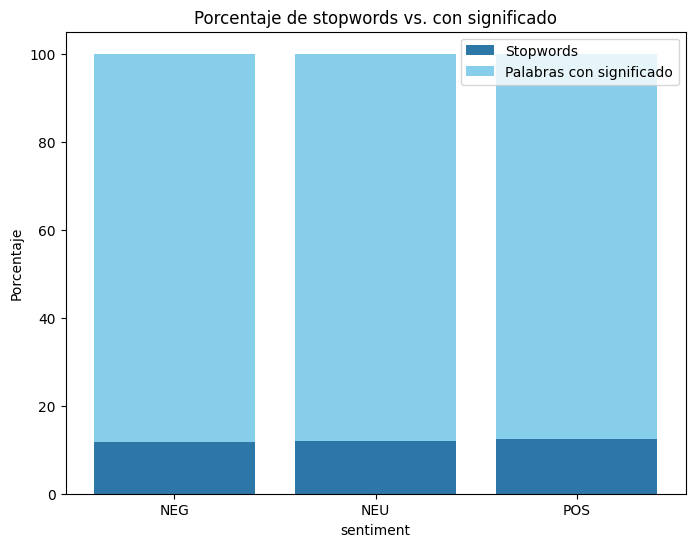

In [10]:
process_text_column2(df, 'review')
graphics_stopwords(df, 'sentiment')

Podemos ver como el porcentaje de stopwords es de alrededor del 15%

In [11]:
# Definir el patrón para los caracteres especiales
pat = '[{}]'.format(re.escape(string.punctuation))

# Definir la función para normalizar, lematizar y eliminar puntuación
def normalize_document_remove_punct(doc):

    doc = re.sub(r'\d+', '', doc)
    # Separamos en tokens
    tokens = nlp(doc)
    
    # Quitamos puntuación, espacios y stopwords, y aplicamos lematización
    filtered_tokens = [re.sub(pat, ' ', t.lemma_.lower())  # Usamos t.lemma_ para lematizar
                       for t in tokens
                       if not t.is_stop        # Eliminar stopwords
                       and not t.is_punct      # Eliminar puntuación
                       and not t.is_space]      # Eliminar espacios]     
    
    # Juntamos de nuevo en una cadena
    doc = ' '.join(filtered_tokens)
    
    return doc

# Aplicar la función a cada elemento de la columna 'contenido' tanto en treino como en test
df['review'] = df['review'].apply(normalize_document_remove_punct)

df.head(5)

,Unnamed: 0,movie,username,date,score,review,sentiment,stopword_percentage
0,0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,absolutely brilliant film character deep plot ...,POS,16.875000
3,3,Moonlight 2016,NWR1,"Mar 31, 2024",9,feel emotion long time chiron manifest emotion...,POS,12.867647
5,5,Moonlight 2016,Youngoth,"Oct 16, 2023",10,movie masterpiece deserve oscar,POS,10.294118
6,6,Moonlight 2016,Dominik08,"Aug 15, 2023",8,refined production obvious weakness base ratio...,POS,13.333333
7,7,Moonlight 2016,AgentLvi,"Jun 27, 2023",7,decent movie story so scoring great visual d...,POS,13.131313


## Exploratorio

Aplicamos una tokenización a los datos, para separar las palabras que tenemos en tokens para poder estudiarlo de manera clara y concisa. 

In [12]:
def process_text_column(df, text_column, lemmatizer=None):
    df['tokens'] = df[text_column].apply(nlp)
    return df

In [13]:
process_text_column(df, "review")

,Unnamed: 0,movie,username,date,score,review,sentiment,stopword_percentage,tokens
0,0,Moonlight 2016,Randomsquirrel,"Jan 15, 2025",10,absolutely brilliant film character deep plot ...,POS,16.875000,"(absolutely, brilliant, film, character, deep,..."
3,3,Moonlight 2016,NWR1,"Mar 31, 2024",9,feel emotion long time chiron manifest emotion...,POS,12.867647,"(feel, emotion, long, time, chiron, manifest, ..."
5,5,Moonlight 2016,Youngoth,"Oct 16, 2023",10,movie masterpiece deserve oscar,POS,10.294118,"(movie, masterpiece, deserve, oscar)"
6,6,Moonlight 2016,Dominik08,"Aug 15, 2023",8,refined production obvious weakness base ratio...,POS,13.333333,"(refined, production, obvious, weakness, base,..."
7,7,Moonlight 2016,AgentLvi,"Jun 27, 2023",7,decent movie story so scoring great visual d...,POS,13.131313,"(decent, movie, story, , so, scoring, great,..."
...,...,...,...,...,...,...,...,...,...
6087,2454,The Diary Of A Teenage Girl,THE_COCONUT_MAN,"Feb 10, 2016",0,find graphic repeat portrayal age sex disturbi...,NEG,13.043478,"(find, graphic, repeat, portrayal, age, sex, d..."
6088,2455,The Diary Of A Teenage Girl,kkcreevy,"Dec 21, 2015",3,yes teen think sex tell young girl daughter su...,NEG,10.312500,"(yes, teen, think, sex, tell, young, girl, dau..."
6089,2456,The Diary Of A Teenage Girl,bevo76,"Sep 3, 2015",0,find movie boring start interesting premise re...,NEG,10.452962,"(find, movie, boring, start, interesting, prem..."
6090,2457,The Diary Of A Teenage Girl,mandm1951,"Aug 30, 2015",3,learn beware critic score high user score movi...,NEG,12.000000,"(learn, beware, critic, score, high, user, sco..."


Podemos graficar la distribución de longitud de textos para cada clase.

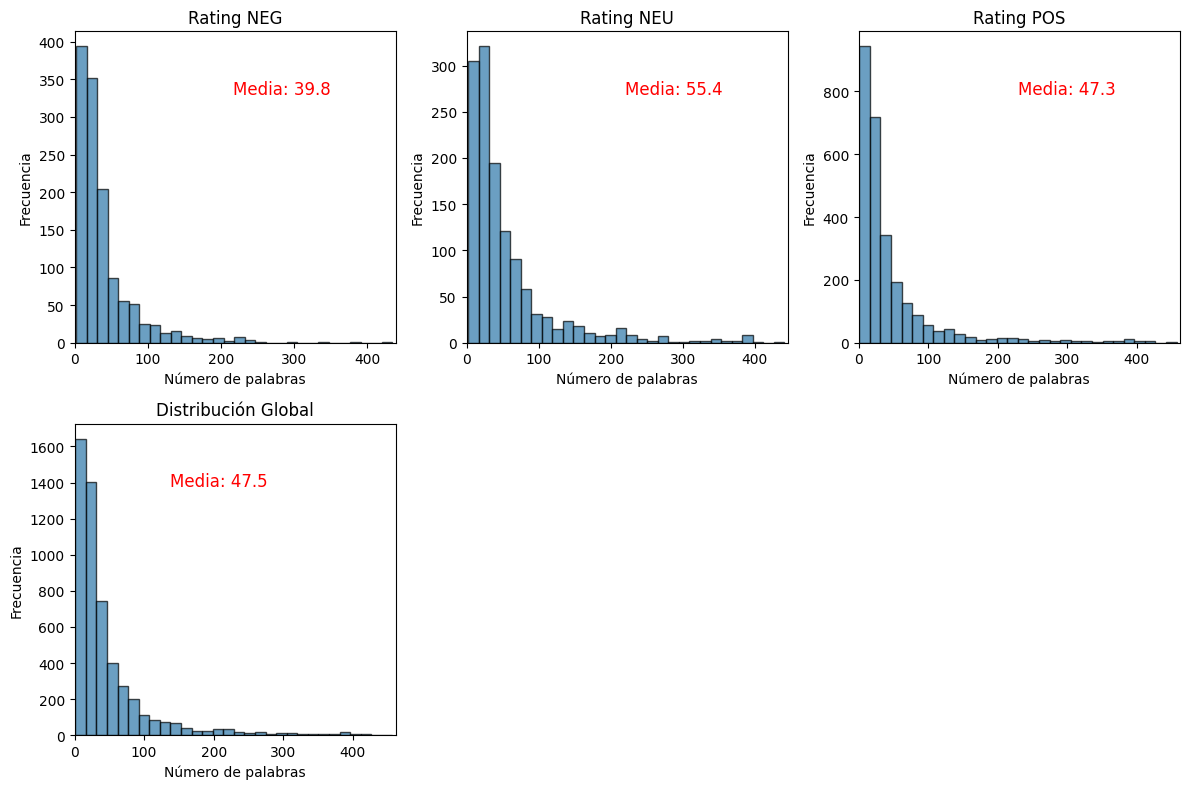

In [14]:
def graficar_longitud_textos(df, text_column, rating_column):
    df['NP'] = df[text_column].apply(len)

    ratings = sorted(df[rating_column].unique())
    num_ratings = len(ratings)
    num_cols = min(3, num_ratings + 1)
    num_rows = (num_ratings + 1 + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))
    axes = np.ravel(axes)

    for i, rating in enumerate(ratings):
        ax = axes[i]
        subset = df[df[rating_column] == rating]
        media_np = subset['NP'].mean()
        max_np = subset['NP'].max()

        ax.hist(subset['NP'], bins=30, edgecolor='black', alpha=0.7, color='#2C77A8')
        ax.set_xlim(0, max_np + 5)  # Añadimos un margen para mejor visualización
        ax.set_xlabel('Número de palabras')
        ax.set_ylabel('Frecuencia')
        ax.set_title(f'Rating {rating}')

        ax.text(max_np * 0.5, ax.get_ylim()[1] * 0.8, f'Media: {media_np:.1f}', fontsize=12, color='red')

    # Gráfico global al final
    global_ax = axes[num_ratings]
    media_global = df['NP'].mean()
    max_np_global = df['NP'].max()

    global_ax.hist(df['NP'], bins=30, edgecolor='black', alpha=0.7, color='#2C77A8')
    global_ax.set_xlim(0, max_np_global + 5)
    global_ax.set_xlabel('Número de palabras')
    global_ax.set_ylabel('Frecuencia')
    global_ax.set_title('Distribución Global')
    global_ax.text(max_np_global * 0.3, global_ax.get_ylim()[1] * 0.8, f'Media: {media_global:.1f}', fontsize=12, color='red')

    # Eliminar subplots vacíos si hay
    for j in range(num_ratings + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

graficar_longitud_textos(df, 'tokens', 'sentiment')

Vemos como la mayoría de los textos tienen una longitud parecida para cada clase, la cuál refiere a unas 30-40 palabras por cada reseña, lo cuál nos va a ayudar a saber como se van a aplicar los word embeddings y los distintos modelos a los datos

Para ver las palabras más repetidas por vcada clase obtenemos los wordclouds

In [26]:
def wordclouds(df, column_partition, top_n):

    # Obtener lista de todas las palabras en el dataset
    all_words = [word for tokens in df['tokens'] for word in tokens]

    # Contar frecuencia de palabras
    word_freq = Counter(all_words)

    # Obtener las `top_n` palabras más comunes
    top_words = {word for word, _ in word_freq.most_common(top_n)}

    # Filtrar los tokens eliminando las palabras más comunes
    df['filtered_tokens'] = df['tokens'].apply(lambda tokens: [word for word in tokens if word not in top_words])

    # Generar WordCloud por cada rating
    ratings = sorted(df[column_partition].unique())
    fig, axes = plt.subplots(1, len(ratings), figsize=(20, 5))

    for i, rating in enumerate(ratings):
        #text = ' '.join([' '.join(tokens) for tokens in df[df[column_partition] == rating]['filtered_tokens']])
        text = ' '.join([' '.join(token.text for token in tokens) for tokens in df[df[column_partition] == rating]['filtered_tokens']])

        wordcloud = WordCloud(width=400, height=400, background_color='white').generate(text)

        # Mostrar en subplot
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].axis('off')
        axes[i].set_title(f'{rating}')

    plt.show()


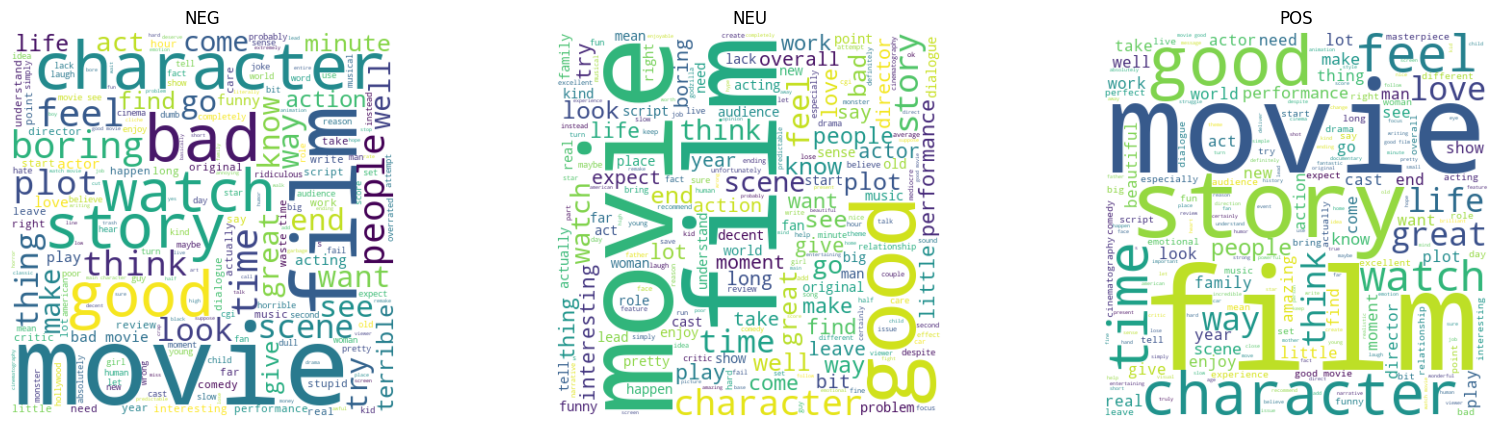

In [27]:
wordclouds(df, 'sentiment', 50)

Podemos ver como en los wordcloud las palabras que más se repiten naturalmente son "movie" y "film", cosa que tiene sentido. Por otro lado, podemos ver algunas palabras típicas de cada conjunto como "bad", "boring" o "bad movie" en el conjunto negativo. En el conjunto neurtro podemos ver como los comentarios suelen reflejar sobre todo comentarios positivos, seguramente por como se estructuran los textos al querer dar una opinión buena pero que al espectador le haya encantado el todo (verbos como feel, palabras que reflejan la fijación en algo como "character", "scene" o "story" para destacar/pasar por alto solo una parte de todo lo que implica el filme... ). Por último, el grupo del grupo positivo tiene sobre todo verbos/adjetivos positivos, por lo que entendemos que el texto esta bien clasificado y podemos proseguir. 

También podemos ver las palabras que mas se repiten 

In [28]:
# Función para obtener n-gramas
def get_ngrams(tokens, n):
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [' '.join(ngram) for ngram in ngrams]

# Función para calcular y graficar bigramas y trigramas más comunes por clases
def plot_most_common_ngrams_by_class(df, text_column, class_column):
    # Crear subgráficos para bigramas
    num_classes = len(df[class_column].unique())
    ncols = 3  # Número de columnas de subgráficos
    nrows = (num_classes + ncols - 1) // ncols  # Calcular número de filas necesarias

    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
    axes = axes.flatten()  # Aplanar la matriz de ejes para facilitar el acceso

    # Generar bigramas
    for i, class_value in enumerate(df[class_column].unique()):

        # Asegúrate de que cada entrada sea una lista de strings
        # Asegúrate de que cada entrada sea una lista de strings
        df['tokens'] = df['tokens'].apply(lambda x: [t.text if hasattr(t, "text") else str(t) for t in x] if isinstance(x, list) else str(x).split())

        # Filtrar los datos por clase
        subset = df[df[class_column] == class_value]

        # Obtener todos los tokens del subset filtrado
        all_words = [word for tokens in subset[text_column] for word in tokens]

        # Calcular bigramas
        bigram_freq = Counter(get_ngrams(all_words, 2))

        # Obtener los 10 bigramas más comunes
        bigram_most_common = bigram_freq.most_common(10)

        # Bigramas
        bigrams, bigram_counts = zip(*bigram_most_common)
        axes[i].barh(bigrams, bigram_counts, color='#a9dfd0', alpha=0.7)

        # Configuración de los gráficos
        axes[i].set_title(f'Bigramas más comunes en {class_value}')
        axes[i].set_xlabel('Frecuencia')
        axes[i].set_ylabel('Bigramas')

    # Ajustar espacio entre subgráficos y mostrar el plot de bigramas
    plt.tight_layout()
    plt.show()

    # Crear subgráficos para trigramas
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
    axes = axes.flatten()  # Aplanar la matriz de ejes para facilitar el acceso

    # Generar trigramas
    for i, class_value in enumerate(df[class_column].unique()):
        # Filtrar los datos por clase
        subset = df[df[class_column] == class_value]

        # Obtener todos los tokens del subset filtrado
        all_words = [word for tokens in subset[text_column] for word in tokens]

        # Calcular trigramas
        trigram_freq = Counter(get_ngrams(all_words, 3))

        # Obtener los 10 trigramas más comunes
        trigram_most_common = trigram_freq.most_common(10)

        # Trigramas
        trigrams, trigram_counts = zip(*trigram_most_common)
        axes[i].barh(trigrams, trigram_counts, color='#2C77A8', alpha=0.7)

        # Configuración de los gráficos
        axes[i].set_title(f'Trigramas más comunes en {class_value}')
        axes[i].set_xlabel('Frecuencia')
        axes[i].set_ylabel('Trigramas')

    # Ajustar espacio entre subgráficos y mostrar el plot de trigramas
    plt.tight_layout()
    plt.show()

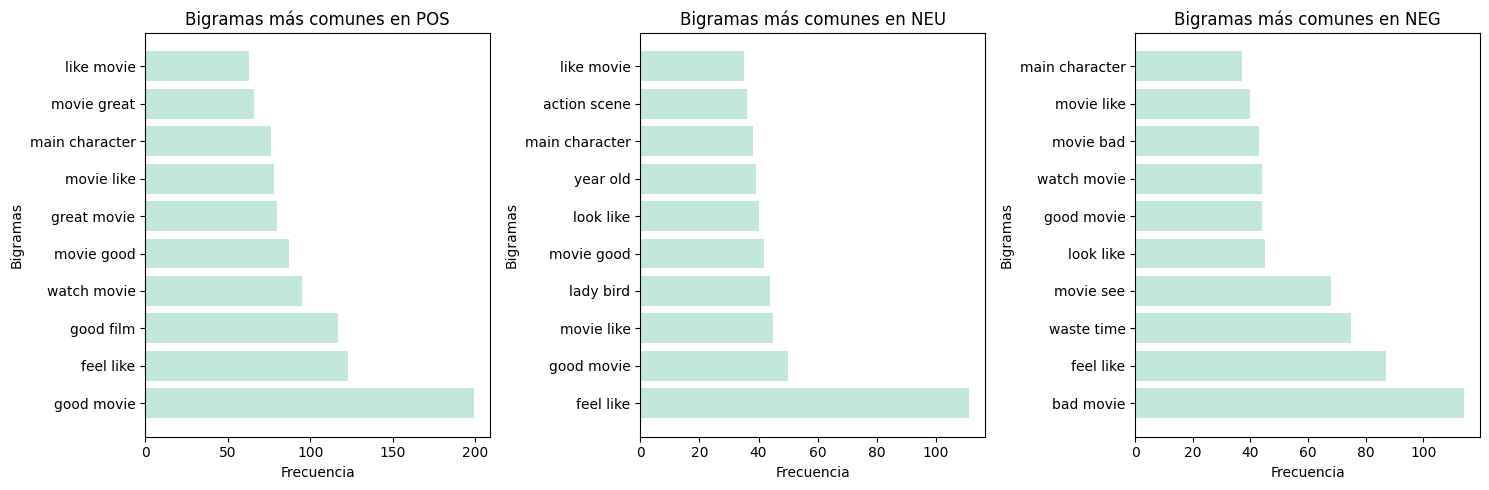

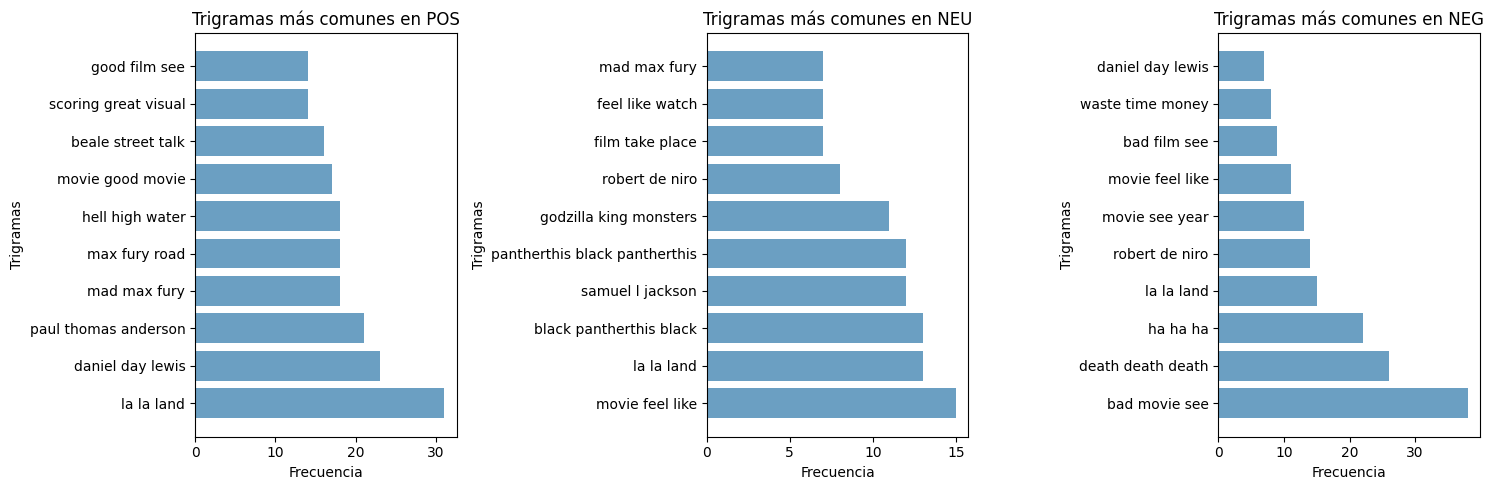

In [29]:
plot_most_common_ngrams_by_class(df, "tokens", "sentiment")

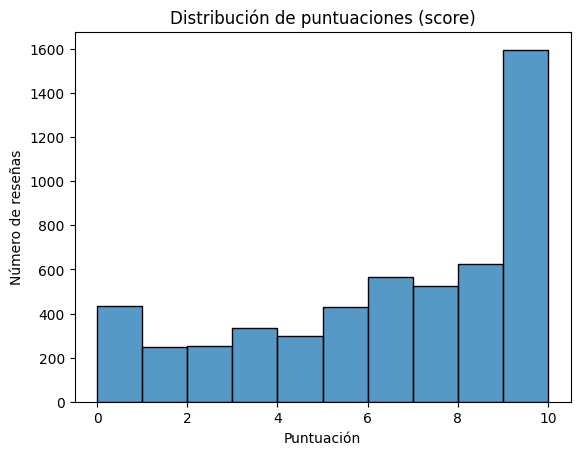

In [29]:
sns.histplot(df['score'].astype(int), bins=10, kde=False)
plt.title('Distribución de puntuaciones (score)')
plt.xlabel('Puntuación')
plt.ylabel('Número de reseñas')
plt.show()


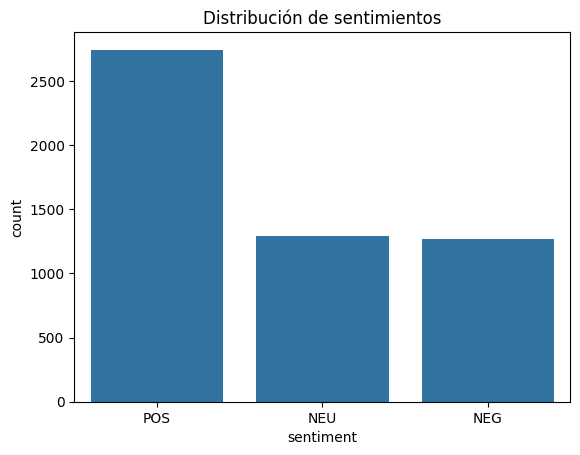

In [30]:
sns.countplot(data=df, x='sentiment')
plt.title('Distribución de sentimientos')
plt.show()

### Extracción de características 

In [15]:
from sklearn.model_selection import train_test_split

# Separar para clasificación de sentimiento
X_train_sent, X_test_sent, y_train_sent, y_test_sent = train_test_split(
    df['review'], df['sentiment'], test_size=0.2, random_state=42)

# Separar para predicción del score
X_train_score, X_test_score, y_train_score, y_test_score = train_test_split(
    df['review'], df['score'].astype(int), test_size=0.2, random_state=42)

In [16]:
df['sentiment']

0       POS
3       POS
5       POS
6       POS
7       POS
       ... 
6087    NEG
6088    NEG
6089    NEG
6090    NEG
6091    NEG
Name: sentiment, Length: 5301, dtype: object

### TF-IDF

In [17]:
vectorizer = TfidfVectorizer()
vectorizer.fit(df['review'])

print("Número total de palabras únicas:", len(vectorizer.vocabulary_))

Número total de palabras únicas: 17770


In [24]:
# Ajustar vectorizador solo con los datos de entrenamiento
tfidf = TfidfVectorizer(max_features=1000)
X_train_sent_vec = tfidf.fit_transform(X_train_sent)
X_test_sent_vec = tfidf.transform(X_test_sent)

X_train_score_vec = tfidf.transform(X_train_score)
X_test_score_vec = tfidf.transform(X_test_score)

### Topic modelling

In [25]:
from sklearn.decomposition import NMF
from scipy.sparse import hstack  # Para concatenar sparse matrices

# Número de temas
n_topics = 20

# Topic modeling con NMF (solo sobre datos de entrenamiento)
nmf = NMF(n_components=n_topics, random_state=42)
W_train_sent = nmf.fit_transform(X_train_sent_vec)  # Representaciones temáticas del train
W_test_sent = nmf.transform(X_test_sent_vec)        # Proyección del test sobre esos mismos temas

W_train_score = nmf.transform(X_train_score_vec)
W_test_score = nmf.transform(X_test_score_vec)

# Concatenar los vectores TF-IDF con las representaciones de tópicos (W matrices)
X_train_sent_topic = hstack([X_train_sent_vec, W_train_sent])
X_test_sent_topic = hstack([X_test_sent_vec, W_test_sent])

X_train_score_topic = hstack([X_train_score_vec, W_train_score])
X_test_score_topic = hstack([X_test_score_vec, W_test_score])

In [26]:
# Acceder al vocabulario
feature_names = tfidf.get_feature_names_out()

# Función para mostrar las top palabras por cada tópico
def display_topics(model, feature_names, no_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        print(f"🔹 Topic {topic_idx}: ", end='')
        top_features_idx = topic.argsort()[:-no_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_idx]
        print(", ".join(top_features))

# Mostrar los temas
display_topics(nmf, feature_names, no_top_words=10)

🔹 Topic 0: life, way, family, people, woman, work, real, know, man, director
🔹 Topic 1: movie, critic, favorite, make, amazing, end, score, understand, wait, give
🔹 Topic 2: good, acting, pretty, actor, opinion, year, thing, job, lot, nice
🔹 Topic 3: bad, horrible, thing, stupid, terrible, plot, cgi, act, actor, acting
🔹 Topic 4: watch, worth, recommend, fun, review, original, want, stop, hard, happen
🔹 Topic 5: great, decent, visual, amazing, voice, cast, sound, cinematography, storyline, design
🔹 Topic 6: action, fun, scene, cruise, max, mission, sequence, tom, impossible, mad
🔹 Topic 7: story, acting, tell, animation, interesting, cinematography, visual, beautiful, excellent, simple
🔹 Topic 8: like, feel, look, people, bit, thing, maybe, kind, scene, style
🔹 Topic 9: film, critic, overall, give, make, well, long, quality, original, theme
🔹 Topic 10: boring, overrated, slow, long, scene, minute, hour, bore, ok, oscar
🔹 Topic 11: character, plot, main, interesting, development, care, 

#### Embedding preentrenado

In [105]:
glove_file_path = './models/glove.twitter.27B.50d.txt'

# Crear un diccionario vacío para almacenar los embeddings
glove_dict = {}

# Leer el archivo y cargar los embeddings en el diccionario
with open(glove_file_path, 'r', encoding='utf-8') as f:
    for line in f:
        # Separar cada línea en la palabra y el vector
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_dict[word] = vector

# Verificar que se ha cargado correctamente el diccionario
print(f"Se han cargado {len(glove_dict)} palabras en el diccionario de GloVe.")

Se han cargado 1193514 palabras en el diccionario de GloVe.


In [106]:
# Función para convertir una reseña en un vector
def text_to_vector(text, glove_dict, dim=50):
    words = text.split()  # Dividir la reseña en palabras (suponiendo que ya están limpias)
    
    # Obtener el vector de cada palabra si está en el diccionario de GloVe
    valid_vectors = [glove_dict[word] for word in words if word in glove_dict]
    
    # Si hay palabras válidas, calcular la media de sus vectores
    if valid_vectors:
        return np.mean(valid_vectors, axis=0)
    else:
        # Si no hay palabras válidas, devolver un vector de ceros
        return np.zeros(dim)

# Aplicar la función a cada reseña en el DataFrame
X_glove = np.vstack(df['review'].apply(lambda x: text_to_vector(x, glove_dict)))

# Verificar la forma de los vectores resultantes
print(X_glove.shape)

(5301, 50)


In [107]:
# Para la tarea de clasificación de sentimiento
X_train_glove_sent, X_test_glove_sent, y_train_sent, y_test_sent = train_test_split(
    X_glove, df['sentiment'], test_size=0.2, random_state=42)

# Para la tarea de predicción del score
X_train_glove_score, X_test_glove_score, y_train_score, y_test_score = train_test_split(
    X_glove, df['score'].astype(int), test_size=0.2, random_state=42)

## Modelos

### TF-IDF + LR

#### Clasificación

In [27]:
le = LabelEncoder()
y_train_sent_enc = le.fit_transform(y_train_sent)
y_test_sent_enc = le.transform(y_test_sent)

modelLR = LogisticRegression(solver='liblinear')
#Entrenamos el modelo con el conjunto de train
modelLR.fit(X_train_score_topic, y_train_sent_enc)
prediccion = modelLR.predict(X_test_score_topic)

print('Accuracy (exactitud): ', accuracy_score(y_test_sent_enc, prediccion))

Accuracy (exactitud):  0.6974552309142319


### Embedding preentrenado + LR

In [110]:
# Crear y entrenar el clasificador
modelLR = LogisticRegression(solver='liblinear')
modelLR.fit(X_train_glove_sent, y_train_sent_enc)

# Realizar predicciones
prediccion = modelLR.predict(X_test_glove_sent)

# Evaluar el modelo
accuracy = accuracy_score(y_test_sent_enc, prediccion)
print('Accuracy (exactitud): ', accuracy)

Accuracy (exactitud):  0.6371347785108389
